<a href="https://colab.research.google.com/github/ganeshred/NLPAuthorshipAttributionNLM/blob/main/LSTM_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.9 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1


In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
from torchtext import data
from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',tokenizer_language='en_core_web_sm', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [ ]:
import pandas as pd

In [ ]:
# df = pd.read_csv('/content/gdrive/MyDrive/task1_final.csv')
df = pd.read_csv('/content/Task1_balanced.csv')

In [ ]:
len(df)

23452

In [ ]:
df.head()

,Unnamed: 0,T1,T2,class
0,1066,Latest Headlines on CNN Business the great shu...,disneyland closes because of the coronavirus o...,0.0
1,1067,China wants to take a victory lap over its han...,"on politics: 'a major war' to the editor: re ""...",0.0
2,1068,Coronavirus disinformation creates challenges ...,most states make it difficult for children to ...,0.0
3,1069,China coronavirus: Eating wild animals made il...,why india's citizenship law crosses the line t...,0.0
4,1070,China's economy could shrink for the first tim...,christchurch mosques shooting victim one-year ...,0.0


In [ ]:
df['text'] = df['T1']+df['T2']

In [ ]:
# df.head()
df = df.rename(columns={'class': 'label'})

In [ ]:


df = df[['text','label']]

In [ ]:
df[['text']] = df[['text']]. astype(str)

In [ ]:
# text_field = data.Field(
#     sequential=True,
#     tokenize='basic_english', 
#     fix_length=500,
#     lower=True
# )
TEXT = data.Field(tokenize = 'spacy', tokenizer_language='en_core_web_sm', include_lengths = True)
LABEL = data.LabelField(sequential=False, use_vocab=False, dtype = torch.float)

# label_field = data.Field(sequential=False, use_vocab=False)

# sadly have to apply preprocess manually
preprocessed_text = df['text'].apply(
    lambda x: TEXT.preprocess(x)
)

# load fastext simple embedding with 300d
TEXT.build_vocab(
    preprocessed_text, 
    max_size = 20000,
    vectors='glove.6B.50d',
    unk_init = torch.Tensor.normal_
)

# get the vocab instance
vocab = TEXT.vocab

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:12<00:00, 31752.87it/s]


In [ ]:
ltoi = {l: i for i, l in enumerate(df['label'].unique())}

In [ ]:
df['label1'] = df['label'].apply(lambda y: ltoi[y])

class DataFrameDataset(data.Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                data.Example.fromlist(list(r), fields) 
                for i, r in df.iterrows()
            ], 
            fields
        )

In [ ]:
df1=df[['text','label1']]

In [ ]:
examples=[]
for i,row in df1.iterrows():
  # print(example)
  examples.append(data.Example.fromlist(row, fields=[('text', TEXT), ('label', LABEL)]))

In [ ]:
# examples[2000].label
c=0
for i in examples:
  if type(i.label) != int:
    c+=1

In [ ]:
c

0

In [ ]:
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

In [ ]:
train_dataset, test_dataset, valid_dataset = dataset.split(split_ratio=[0.6, 0.2, 0.2], stratified=True, strata_field='label')

In [ ]:
len(train_dataset)

14072

In [ ]:
ltoi

{0.0: 0, 1.0: 1}

In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are working with ", device)
# device = 'cpu'
train_iter, test_iter, valid_iter = data.BucketIterator.splits(
    datasets=(train_dataset, test_dataset, valid_dataset), 
    batch_size=16,
    sort_within_batch = True,
    sort_key=lambda x: len(x.text),
    device=device
)

We are working with  cuda


In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        #1. Initialize Embedding Layer
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim, padding_idx = pad_idx)
        #2. Initialize LSTM layer
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = n_layers, dropout = dropout, bidirectional = bidirectional)
        #3. Initialize a fully connected layer with Linear transformation
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        #4. Initialize Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        #1. Apply embedding layer that matches each word to its vector and apply dropout. Dim [sent_len, batch_size, emb_dim]
        embedding = self.embedding(text)
        embedding_dropout = self.dropout(embedding)
        #2. Run the LSTM along the sentences of length sent_len. #output = [sent len, batch size, hid dim * num directions]; #hidden = [num layers * num directions, batch size, hid dim]
        output, (hidden,cell) = self.lstm(embedding_dropout)
        #3. Concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers and apply dropout
        concat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        hidden = self.dropout(concat)     
        return self.fc(hidden)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 126
OUTPUT_DIM = 2
N_LAYERS = 2
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTM(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT,
            PAD_IDX)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,218,334 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([20002, 50])


In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  0.7372,  0.3910,  0.5158],
        [ 0.1825, -0.0737,  0.3147,  ...,  1.3226, -2.6796, -0.1297],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [ 1.1941, -0.9230, -0.6889,  ...,  0.3863, -0.8096,  1.2940],
        [ 0.7168,  0.0894,  0.0470,  ..., -0.2375,  0.5867, -1.3436],
        [ 0.8518, -0.1653, -0.7702,  ..., -0.0852, -0.6297, -0.0945]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [ 1.1941, -0.9230, -0.6889,  ...,  0.3863, -0.8096,  1.2940],
        [ 0.7168,  0.0894,  0.0470,  ..., -0.2375,  0.5867, -1.3436],
        [ 0.8518, -0.1653, -0.7702,  ..., -0.0852, -0.6297, -0.0945]])


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss()

# device='cpu'
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# def binary_accuracy(preds, y):
#     """
#     Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
#     """
#     # get the index of the highest prediction for each instance
#     _, preds = torch.max(preds, dim=1)
#     correct = (preds == y).float() #convert into float for division 
#     acc = correct.sum() / len(correct)
#     return acc

# def binary_accuracy(preds, y):
#     """
#     Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
#     """
#     #round predictions to the closest integer
#     rounded_preds = torch.round(torch.sigmoid(preds))
#     # predicted_labels = torch.argmax(rounded_preds, dim=1)

#     # print(predicted_labels.shape)
#     # print(y.shape)
#     correct = (rounded_preds == y).float() #convert into float for division 
#     acc = correct.sum() / len(correct)
#     return acc

def multiclass_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # get the index of the highest prediction for each instance
    _, preds = torch.max(preds, dim=1)
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc


In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        # print(batch.text)
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)

        target = batch.label
        target = target.type(torch.LongTensor)

        # print(target)

        # print(predictions)
        
        loss = criterion(predictions.to(device), target.to(device))
        
        acc = multiclass_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            
            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            target = batch.label
            target = target.type(torch.LongTensor)
            
            loss = criterion(predictions.to(device), target.to(device))
            
            acc = multiclass_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_losses_list = []
valid_losses_list = []
train_accs=[]
valid_accs=[]

In [ ]:
N_EPOCHS = 25
path = F"/content/gdrive/My Drive/bilstm_model_task1.pt"
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    # torch.cuda.empty_cache()
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path)

    train_losses_list.append(train_loss)
    valid_losses_list.append(valid_loss)
    train_accs.append(train_acc*100)
    valid_accs.append(valid_acc*100)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 0.652 | Train Acc: 64.48%
	 Val. Loss: 0.663 |  Val. Acc: 60.65%
Epoch: 02 | Epoch Time: 0m 30s
	Train Loss: 0.645 | Train Acc: 65.01%
	 Val. Loss: 0.746 |  Val. Acc: 57.50%
Epoch: 03 | Epoch Time: 0m 31s
	Train Loss: 0.638 | Train Acc: 65.26%
	 Val. Loss: 0.680 |  Val. Acc: 58.89%
Epoch: 04 | Epoch Time: 0m 31s
	Train Loss: 0.629 | Train Acc: 65.19%
	 Val. Loss: 0.688 |  Val. Acc: 59.82%
Epoch: 05 | Epoch Time: 0m 31s
	Train Loss: 0.612 | Train Acc: 65.72%
	 Val. Loss: 0.660 |  Val. Acc: 60.23%
Epoch: 06 | Epoch Time: 0m 30s
	Train Loss: 0.602 | Train Acc: 65.87%
	 Val. Loss: 0.660 |  Val. Acc: 61.12%
Epoch: 07 | Epoch Time: 0m 31s
	Train Loss: 0.599 | Train Acc: 66.48%
	 Val. Loss: 0.677 |  Val. Acc: 59.99%
Epoch: 08 | Epoch Time: 0m 31s
	Train Loss: 0.594 | Train Acc: 66.63%
	 Val. Loss: 0.671 |  Val. Acc: 60.37%
Epoch: 09 | Epoch Time: 0m 30s
	Train Loss: 0.591 | Train Acc: 67.09%
	 Val. Loss: 0.682 |  Val. Acc: 60.52%
Epoch: 10 | Epoch T

In [ ]:
test_loss, test_acc = evaluate(model, test_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.840 | Test Acc: 50.43%


In [ ]:
test_loss, test_acc = evaluate(model, valid_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.854 | Test Acc: 48.77%


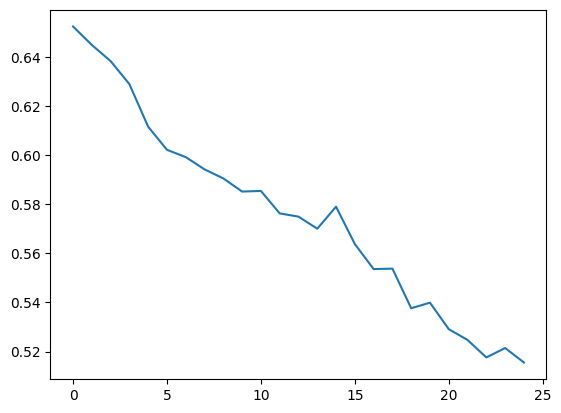

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses_list)

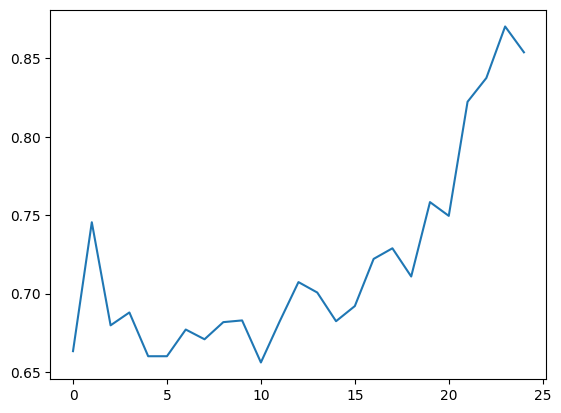

In [ ]:
plt.plot(valid_losses_list)

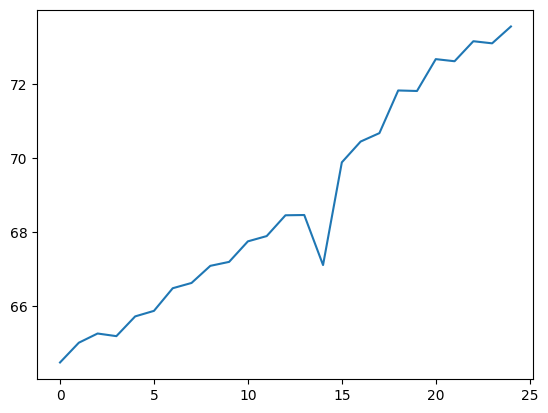

In [ ]:
plt.plot(train_accs)

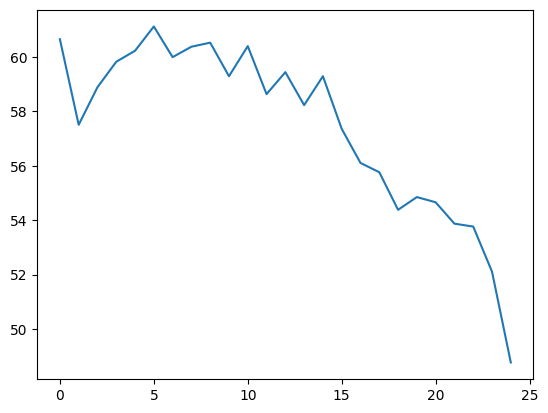

In [ ]:
plt.plot(valid_accs)